SIMPLEST possible application case: don't do any fine-tuning of existing model weights; just learn a frame-level decoder. Can we do it?

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from pathlib import Path

import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
import transformers

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
test_dataset_path = "out/rnn/rnn2_hidden128_drop6/checkpoint-3850/test_result/"
test_dataset = datasets.load_from_disk(test_dataset_path)

In [5]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Viz

In [6]:
viz_columns = [None] * tokenizer.vocab_size
for token, idx in tokenizer.get_vocab().items():
    if idx < tokenizer.vocab_size:
        viz_columns[idx] = token

In [7]:
def plot_timit_items(idxs, phone_plot_key="phonemic_detail"):
    f, axs = plt.subplots(len(idxs), figsize=(20, 8 * len(idxs)))

    for idx, ax in zip(idxs, axs.ravel()):
        item = test_dataset[idx]

        # compute compression ratio between input and output
        compression_ratio = item["compression_ratio"]

        word_detail = item["word_detail"]
        word_starts = set()
        for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
            start = start * compression_ratio
            stop = stop * compression_ratio
            word_starts.add(start)

            ax.axhline(start, color="white", linestyle="--")
            # show phone centered over its span
            ax.text(-2, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

        for i, (start, stop, phon) in enumerate(zip(item[phone_plot_key]["start"], item[phone_plot_key]["stop"], item[phone_plot_key]["utterance"])):
            start = start * compression_ratio
            stop = stop * compression_ratio

            if start not in word_starts:
                ax.axhline(start, color="white", linestyle="--", alpha=0.5)
            
            # show phone centered over its span
            ax.text(0, (start + stop) / 2, phon, ha="right", va="center", fontsize=12)

        yield ax, item

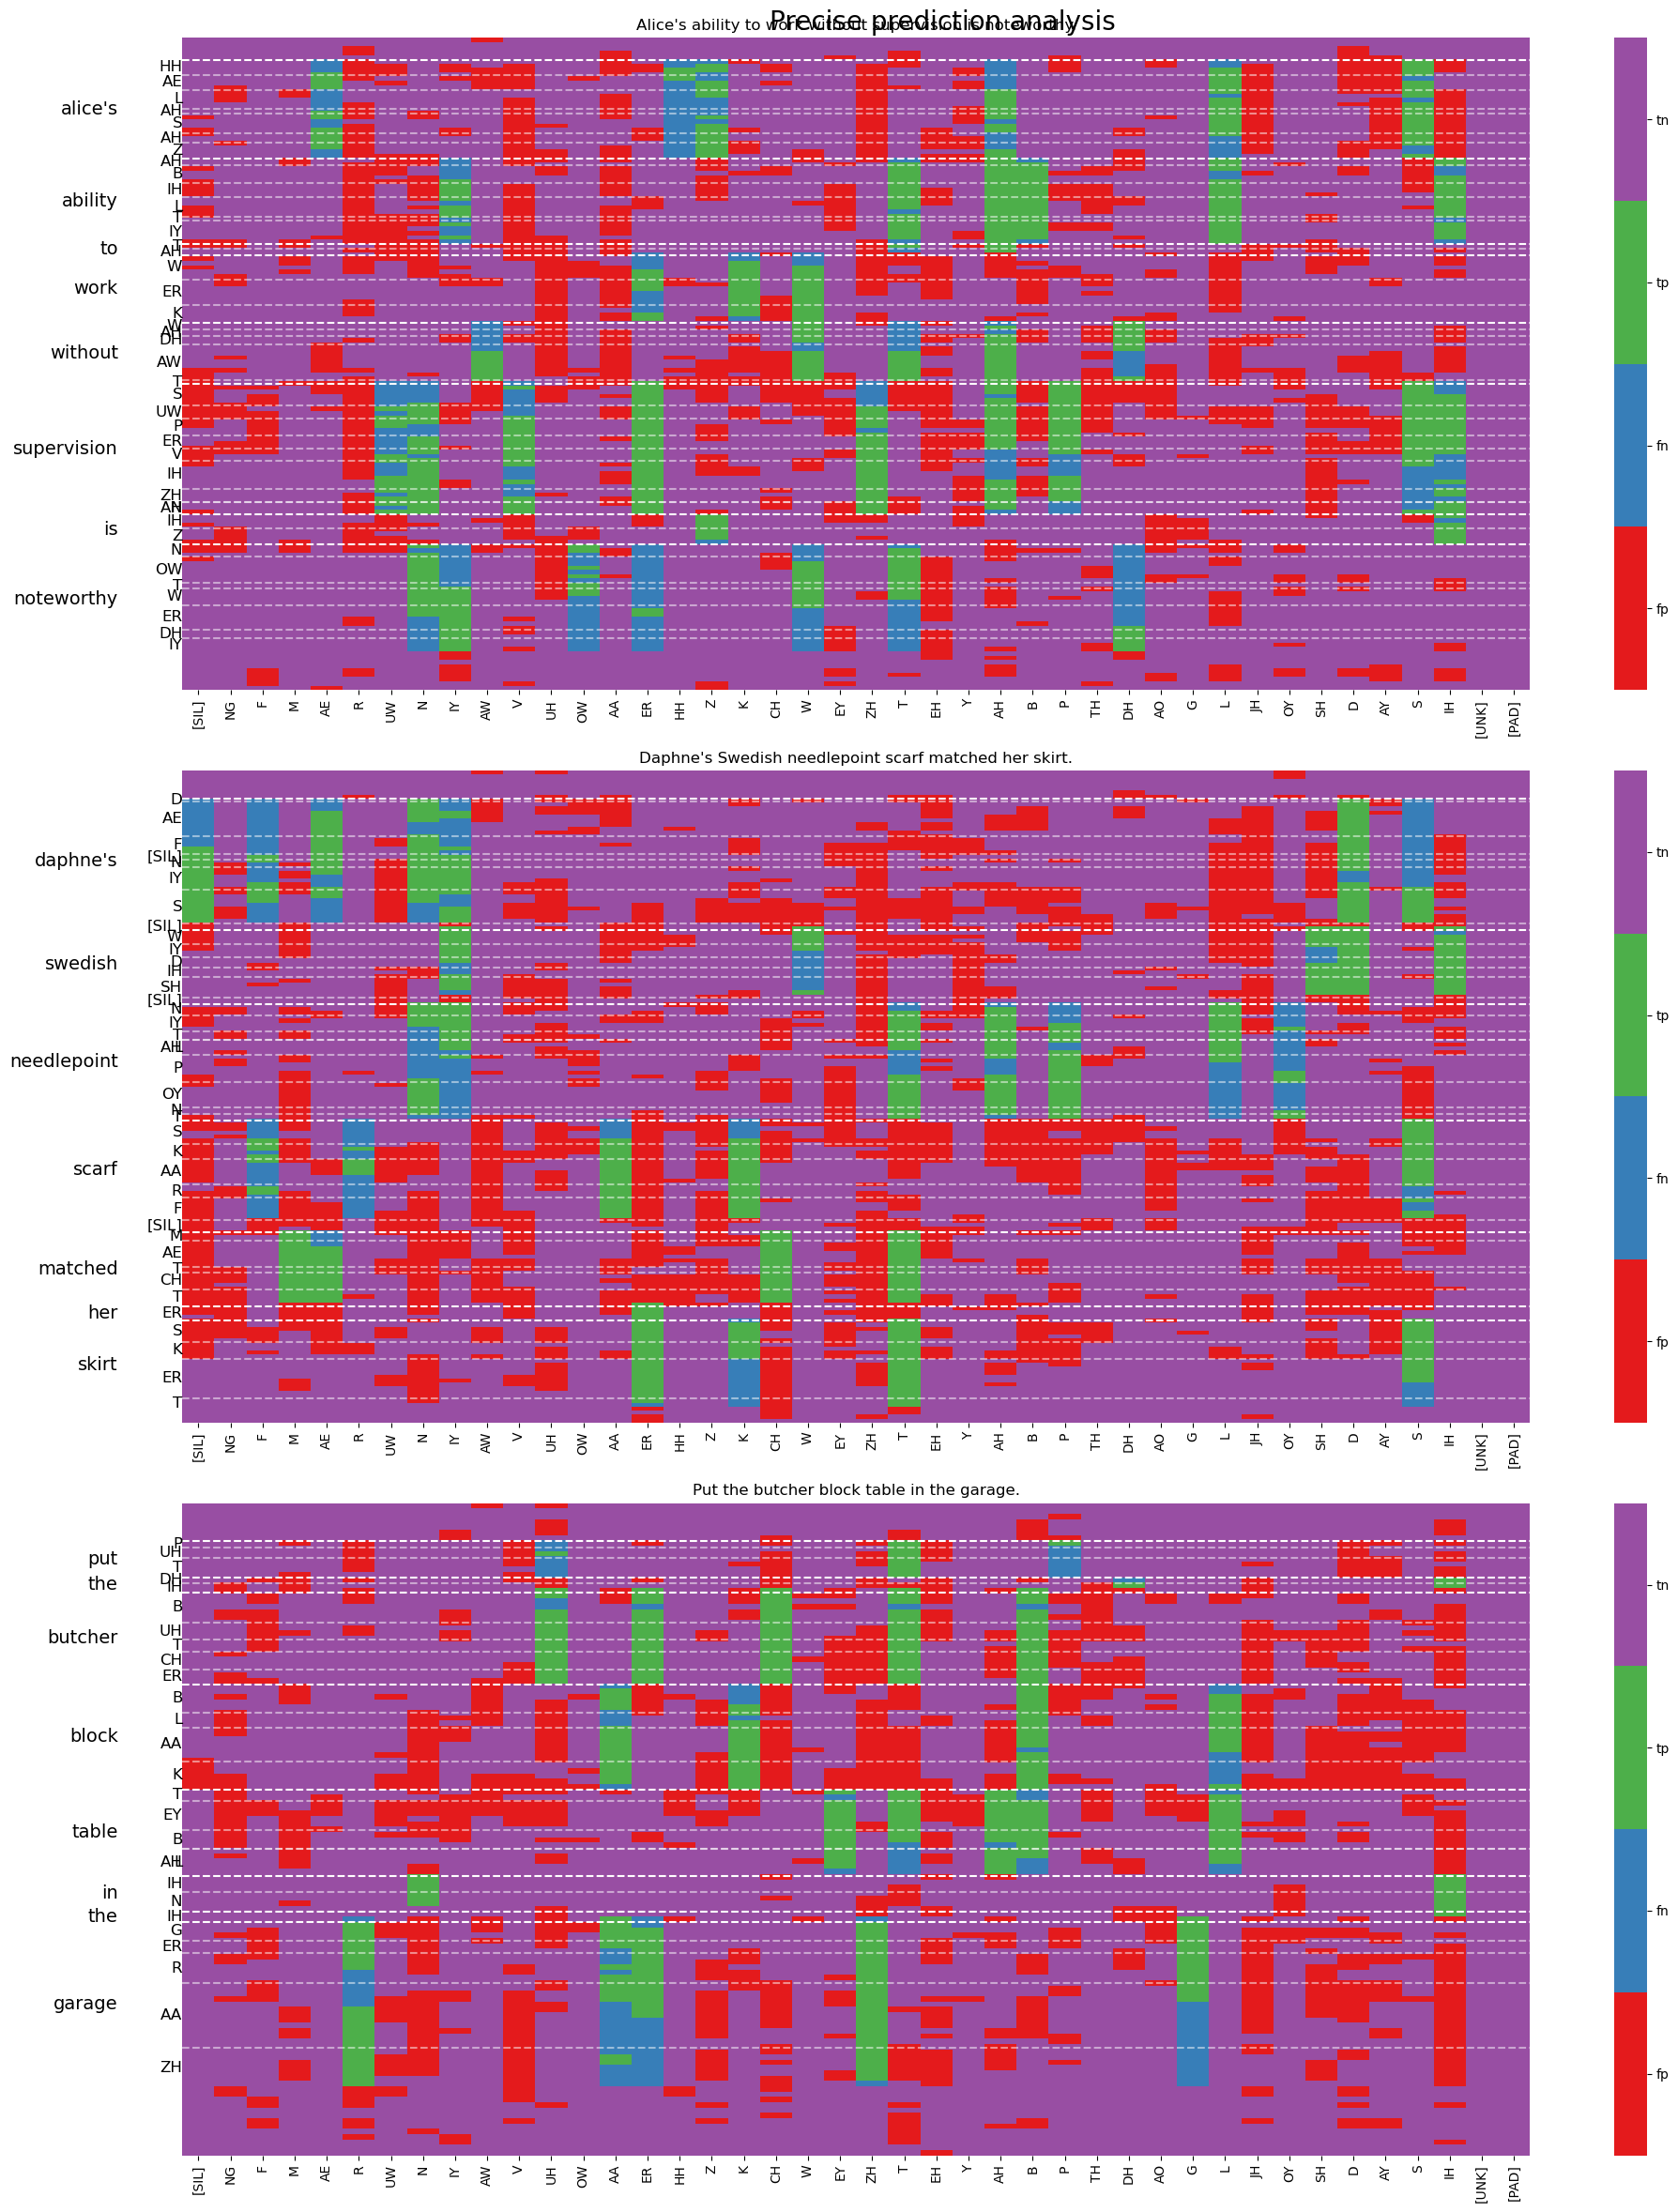

In [8]:
# viz phoneme predictions
n_to_plot = 3
plot_idxs = np.random.choice(len(test_dataset), n_to_plot, replace=False).tolist()

for ax, item in plot_timit_items(plot_idxs):
    data = np.zeros_like(item["correct"]).astype(int)
    data[np.array(item["fp"])] = 1
    data[np.array(item["fn"])] = 2
    data[np.array(item["tp"])] = 3
    data[np.array(item["tn"])] = 4
    color_labels = ["fp", "fn", "tp", "tn"]

    # result = pd.DataFrame(np.array(item["correct"])[:num_item_frames], columns=viz_columns)
    result = pd.DataFrame(data[:item["real_frames"]], columns=viz_columns)
    sns.heatmap(result, ax=ax, cmap=sns.color_palette("Set1", 4))
    ax.set_title(item["text"])
    ax.set_yticks([])
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 4 * (0.5 + i) for i in range(4)])
    colorbar.set_ticklabels(color_labels)

ax.figure.suptitle("Precise prediction analysis", fontsize=20)
ax.figure.tight_layout()

Text(0.5, 0.98, 'Raw predictions')

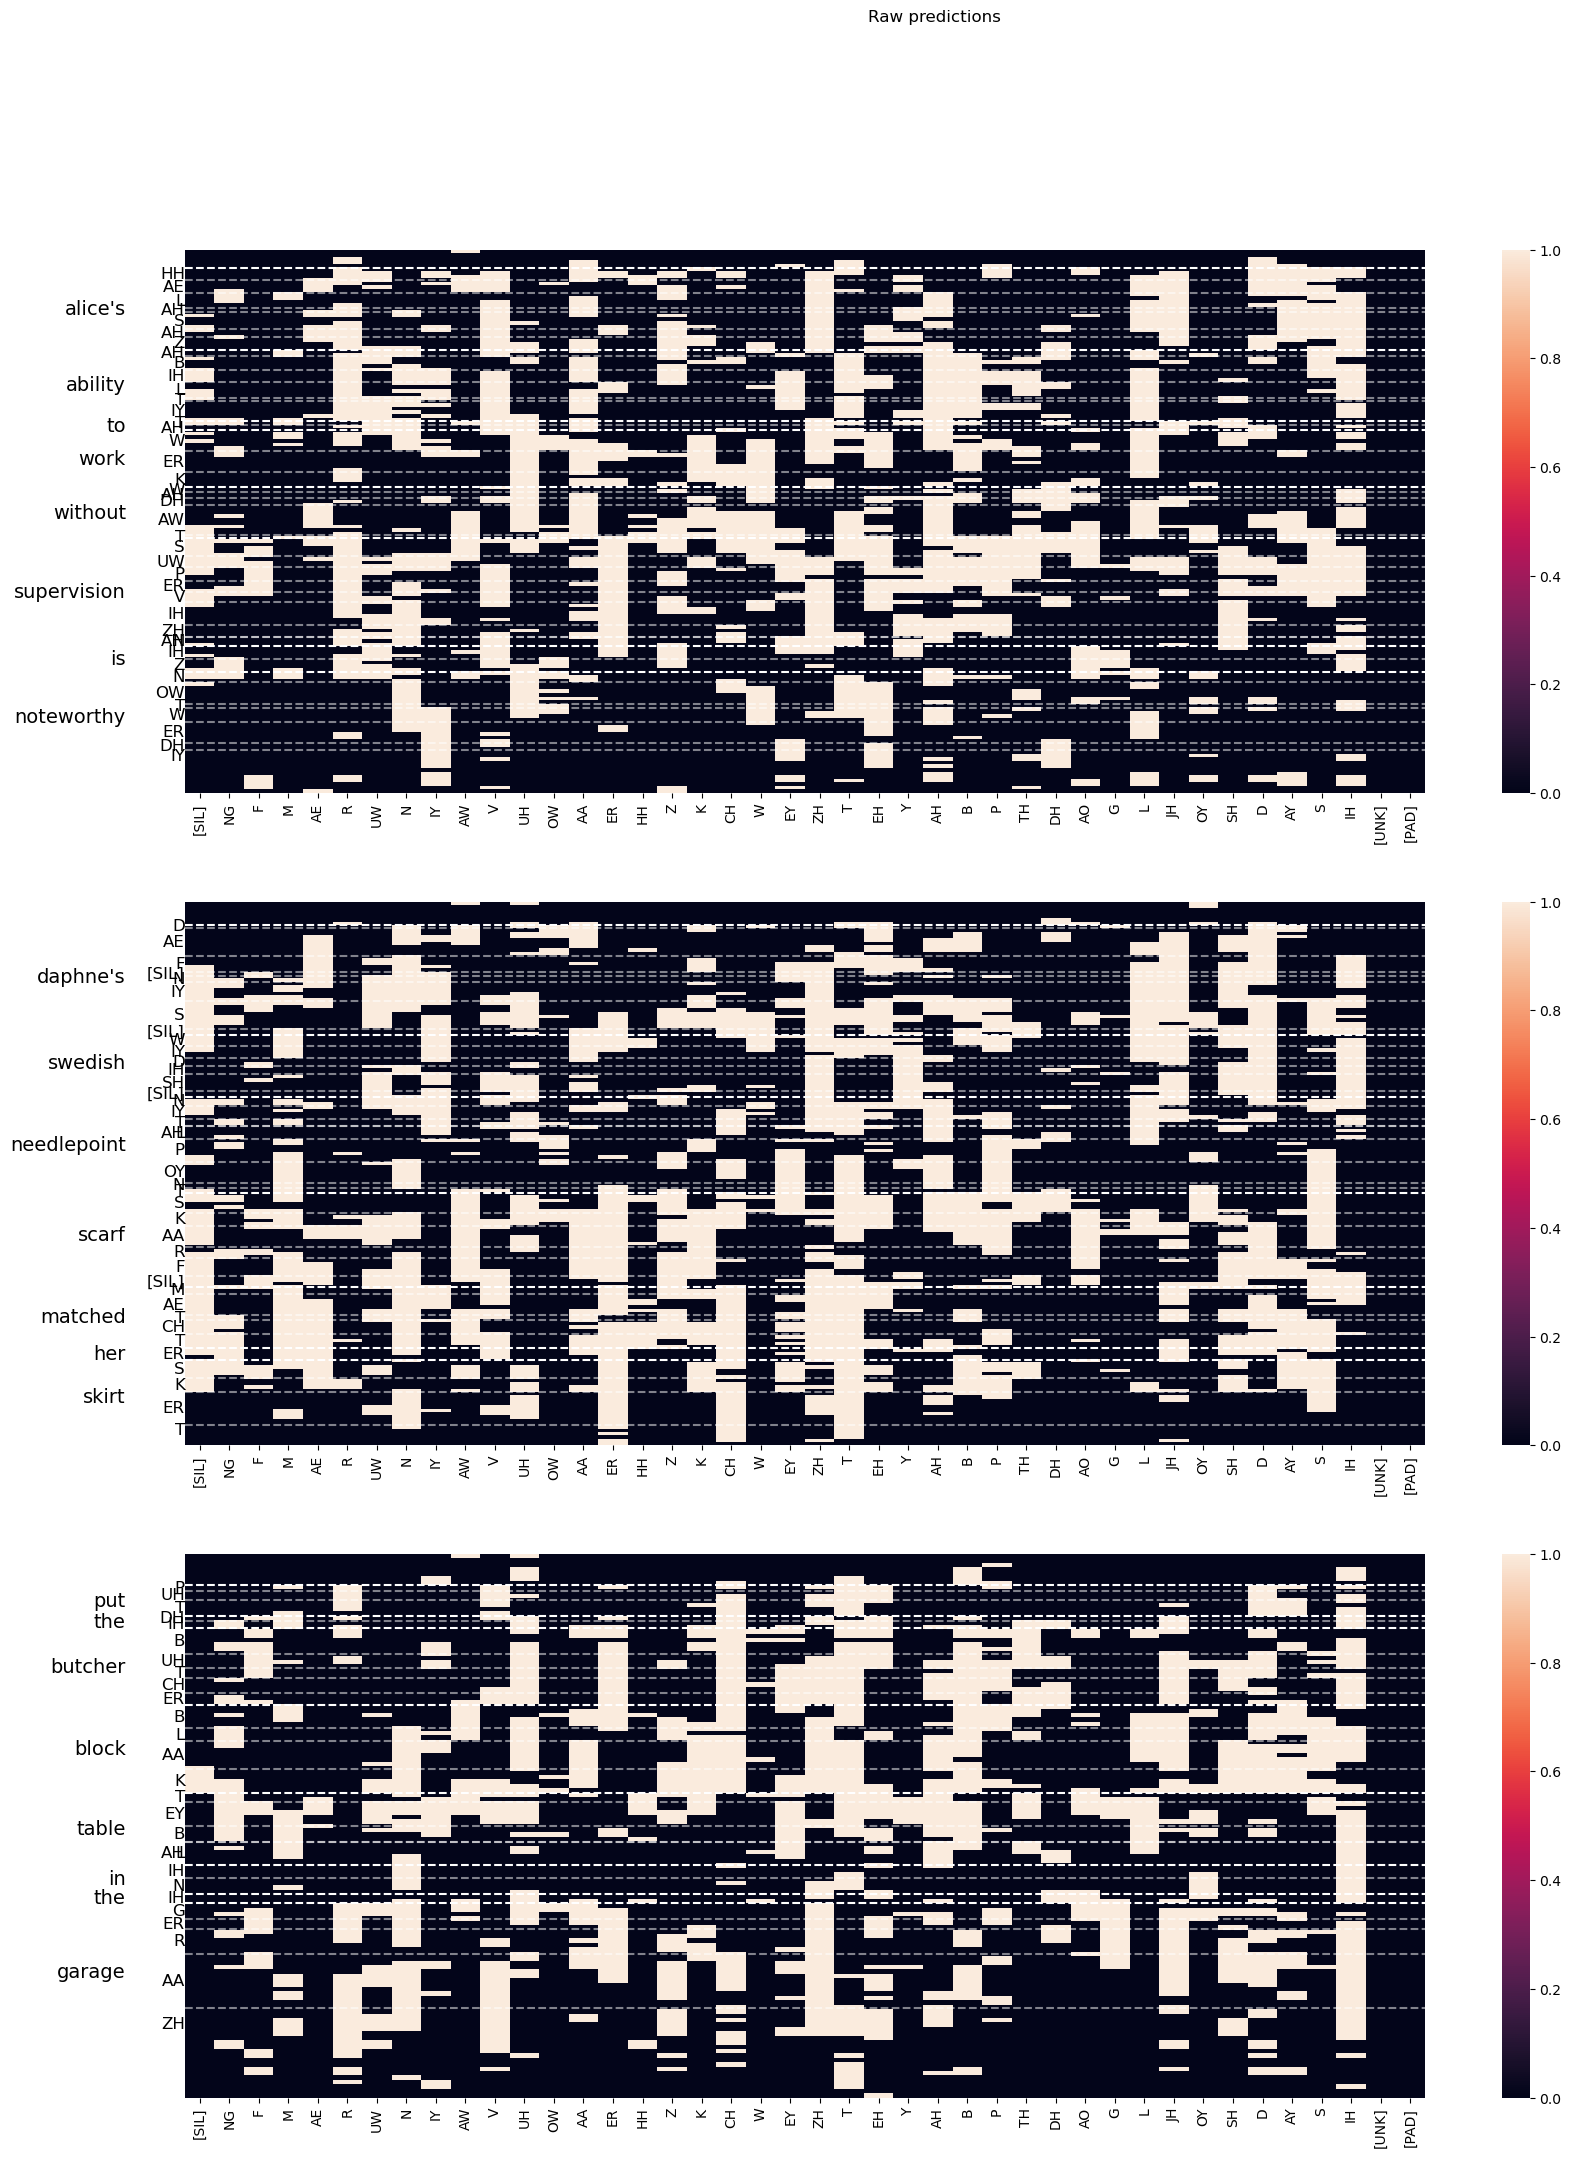

In [9]:
# viz raw predictions
for ax, item in plot_timit_items(plot_idxs):
    result = pd.DataFrame(item["predicted"][:item["real_frames"]],
                          columns=viz_columns)
    sns.heatmap(result, ax=ax)
    ax.set_yticks([])

ax.figure.suptitle("Raw predictions")

Text(0.5, 0.98, 'Ground truth')

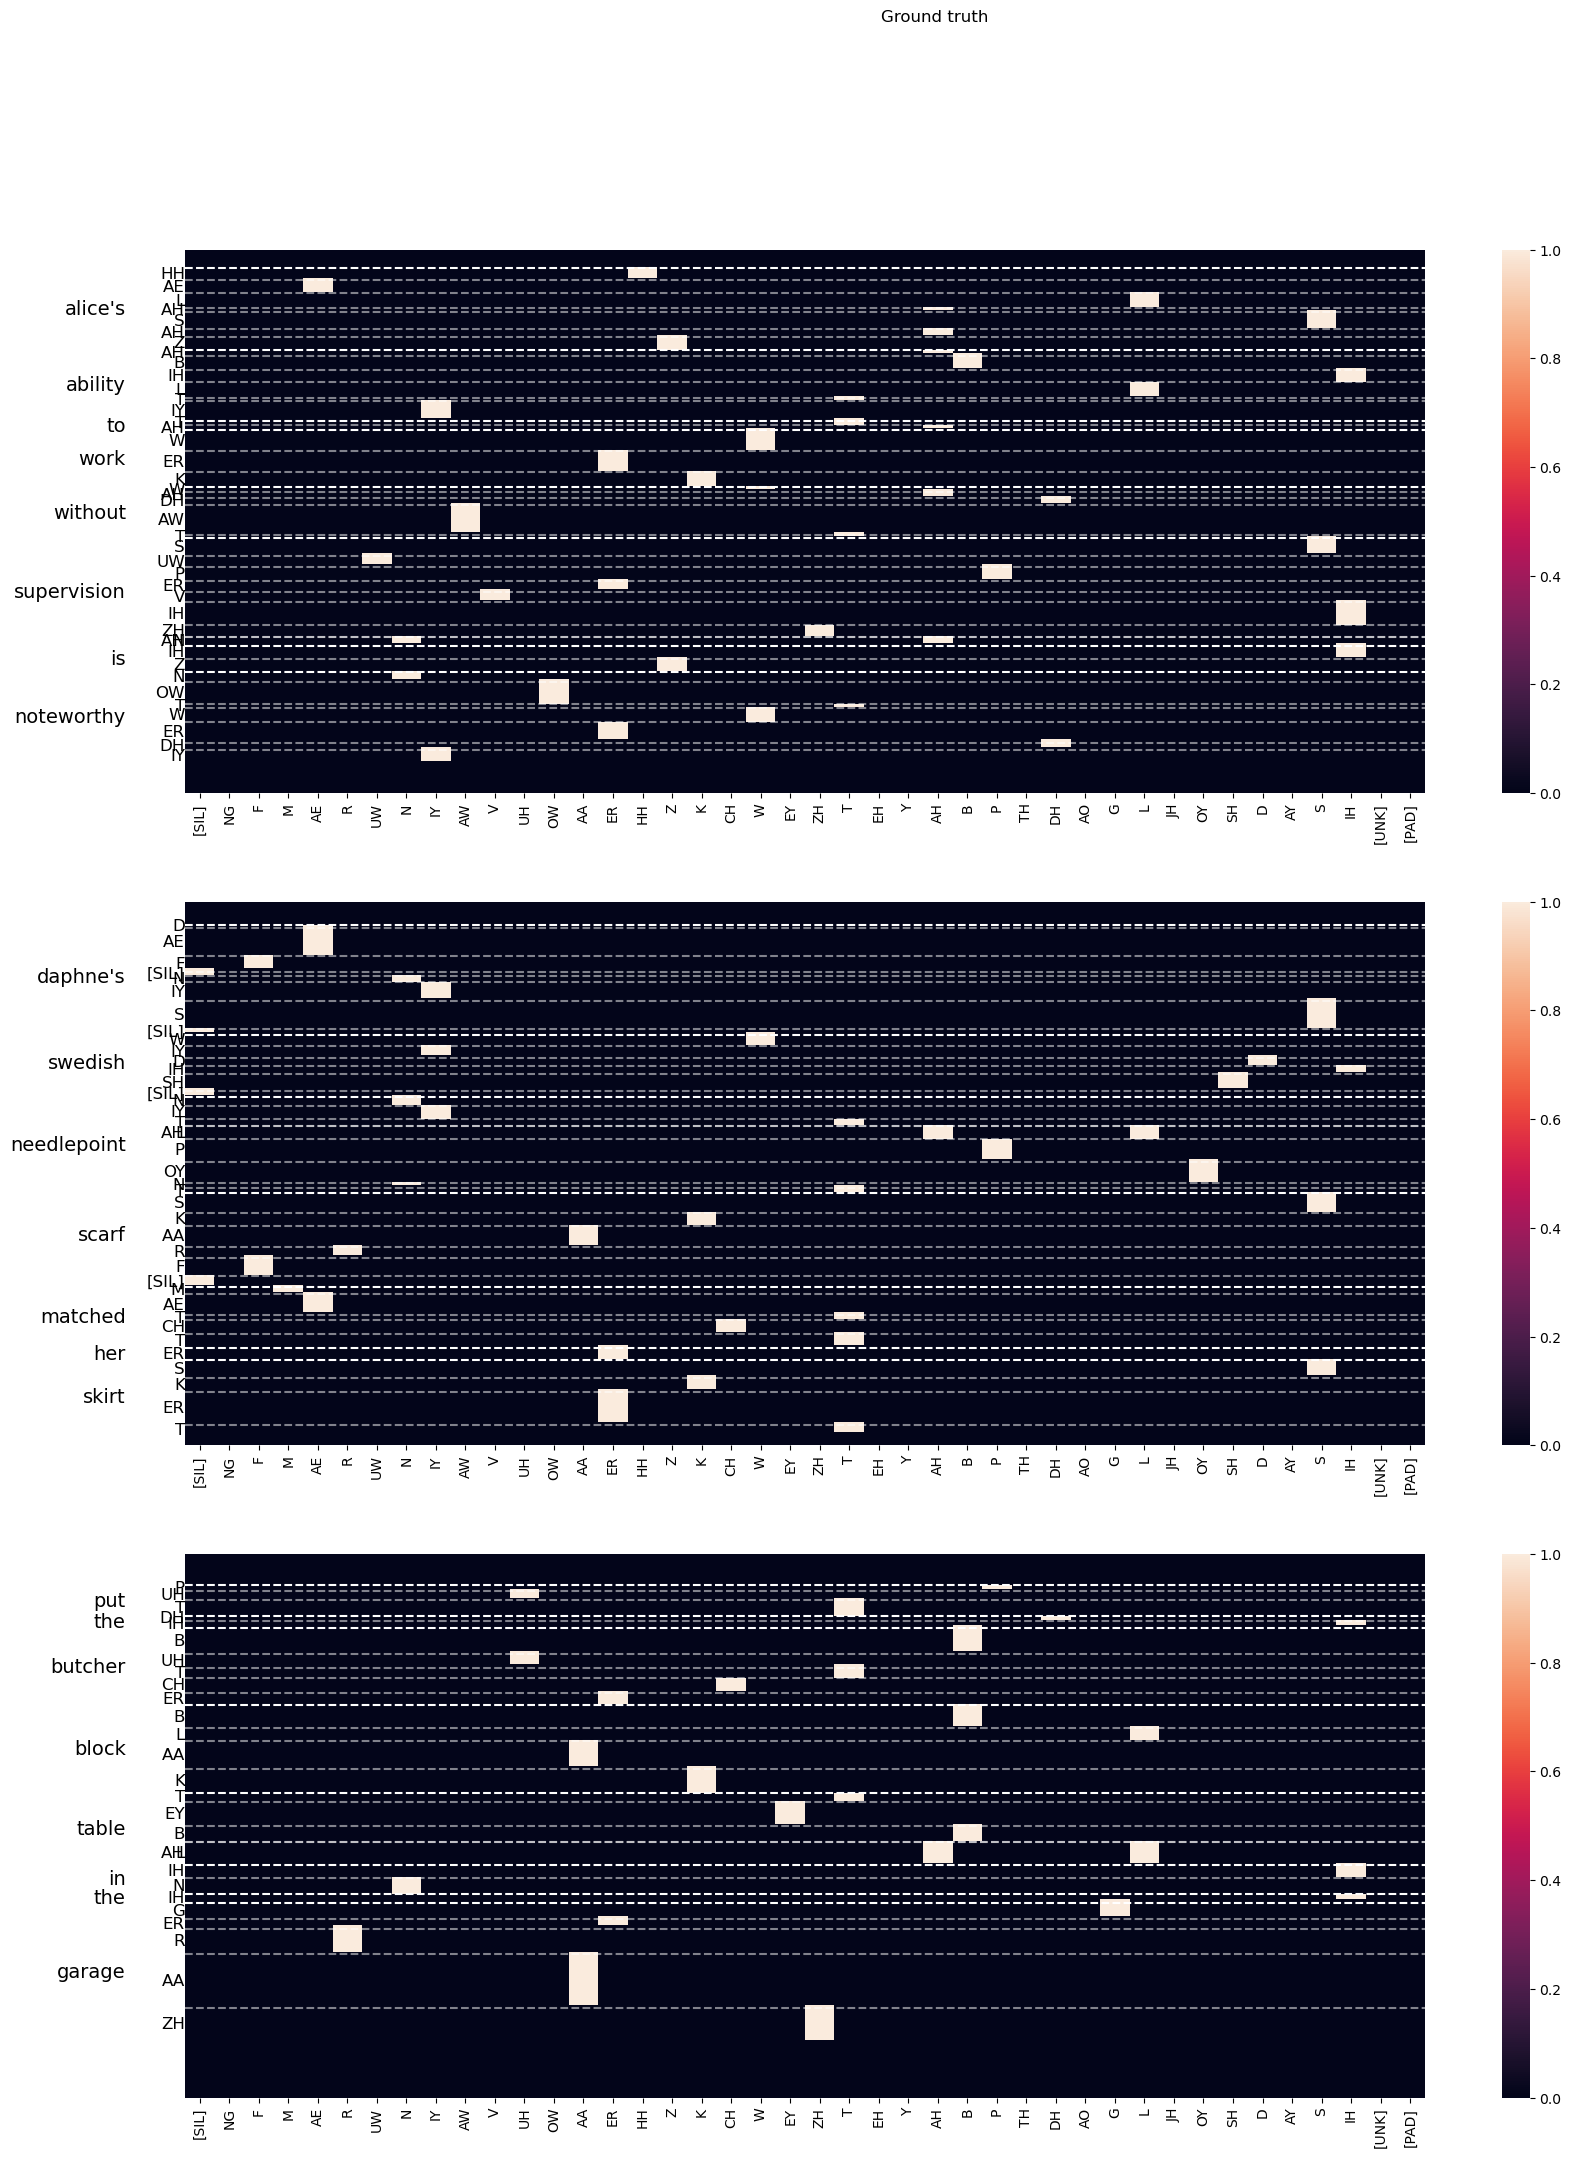

In [14]:
# viz labels
for ax, item in plot_timit_items(plot_idxs):
    compression_ratio = item["compression_ratio"]
    label_mat = np.zeros_like(item["predicted"])
    for start, stop, phone in zip(item["phonemic_detail"]["start"], item["phonemic_detail"]["stop"], item["phonemic_detail"]["utterance"]):
        start = int(start * compression_ratio)
        stop = int(stop * compression_ratio)
        label_mat[start:stop, tokenizer.convert_tokens_to_ids(phone)] = 1

    result = pd.DataFrame(label_mat[:item["real_frames"]], columns=viz_columns)
    sns.heatmap(result, ax=ax)
    ax.set_yticks([])

ax.figure.suptitle("Ground truth")